# Modeling and assessment of ML models

Objectives:
1. Perform feature engineering and train-test data splitting. Create new features from existing categorical data through one-hot encodings.
2. Perform hyperparameter tuning for each model through Gridsearch and 10-fold cross-validation.
3. Perform model assessment through 10-fold cross-validation metrics.
4. Estimate model performance through Classification report and Confusion matrix.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer,f1_score, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


## Load Dataset

In [2]:
data1 = pd.read_csv('merge_stock_news_amazon.csv')
data2 = pd.read_csv('merge_stock_news_tesla.csv')
data1.loc[:,'ticker'] = 'amazon'
data2.loc[:,'ticker'] = 'tesla'
data = data1.append(data2)
#change the type of Date to Datetime
data['Date'] =pd.to_datetime(data.Date)
data = data.sort_values('Date')
data.head()

,Date,Weekday,Yesterday_pos,Yesterday_neg,Yesterday_neu,Positive,Negative,Neutral,Yesterday_price_change,Price_change,Yesterday_open,Yesterday_close,Yesterday_volume,Yesterday_high,Yesterday_low,Yesterday_Adj_close,ticker
0,2017-01-04,Wednesday,0.119593,0.042743,0.837664,0.416015,0.054345,0.529640,NaN,NaN,37.896000,37.683498,70422000,37.938000,37.384998,37.683498,amazon
0,2017-01-04,Wednesday,0.550024,0.351256,0.098720,0.394854,0.198030,0.407116,NaN,1.0,42.972000,43.397999,29616500,44.066002,42.192001,43.397999,tesla
1,2017-01-05,Thursday,0.394854,0.198030,0.407116,0.353168,0.051893,0.594939,1.0,NaN,42.950001,45.397999,56067500,45.599998,42.862000,45.397999,tesla
1,2017-01-05,Thursday,0.416015,0.054345,0.529640,0.128640,0.036761,0.834599,NaN,1.0,37.919498,37.859001,50210000,37.984001,37.709999,37.859001,amazon
2,2017-01-06,Friday,0.128640,0.036761,0.834599,0.222731,0.061406,0.715863,1.0,1.0,38.077499,39.022499,116602000,39.119999,38.013000,39.022499,amazon


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314 entries, 0 to 1153
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2314 non-null   datetime64[ns]
 1   Weekday                 2314 non-null   object        
 2   Yesterday_pos           2314 non-null   float64       
 3   Yesterday_neg           2314 non-null   float64       
 4   Yesterday_neu           2314 non-null   float64       
 5   Positive                2017 non-null   float64       
 6   Negative                2017 non-null   float64       
 7   Neutral                 2017 non-null   float64       
 8   Yesterday_price_change  1346 non-null   float64       
 9   Price_change            1352 non-null   float64       
 10  Yesterday_open          2314 non-null   float64       
 11  Yesterday_close         2314 non-null   float64       
 12  Yesterday_volume        2314 non-null   int64   

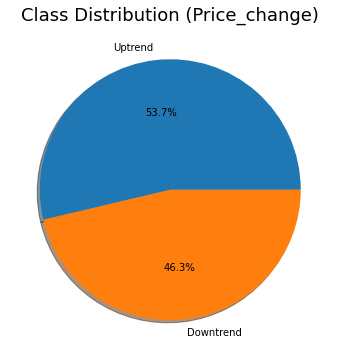

,Yesterday_pos,Yesterday_neg,Yesterday_neu,Positive,Negative,Neutral,Yesterday_price_change,Price_change,Yesterday_open,Yesterday_close,Yesterday_volume,Yesterday_high,Yesterday_low,Yesterday_Adj_close
count,2314.000000,2314.000000,2314.000000,2017.000000,2017.000000,2017.000000,1346.000000,1352.000000,2314.000000,2314.000000,2.314000e+03,2314.000000,2314.000000,2314.000000
mean,0.263232,0.170101,0.566667,0.256946,0.163308,0.579746,0.537890,0.536982,184.765922,184.881556,6.556393e+07,188.203057,181.121400,184.881556
std,0.142614,0.135875,0.169574,0.140752,0.139637,0.170034,0.498748,0.498815,231.839385,232.059054,4.189189e+07,237.046786,226.266364,232.059054
min,0.013175,0.007845,0.034318,0.013175,0.007845,0.034318,0.000000,0.000000,36.220001,35.793999,9.800600e+06,37.335999,35.397999,35.793999
25%,0.158246,0.057743,0.458178,0.152040,0.047222,0.471699,0.000000,0.000000,62.273125,62.251000,3.514312e+07,63.262499,61.099998,62.251000
50%,0.244488,0.145386,0.573218,0.238767,0.132879,0.584196,1.000000,1.000000,88.411499,88.327751,5.664000e+07,89.311497,87.347752,88.327751
75%,0.349994,0.245789,0.681518,0.342105,0.236843,0.700102,1.000000,1.000000,164.995880,164.699623,8.475700e+07,166.553123,163.034630,164.699623
max,0.925848,0.936819,0.938232,0.925848,0.936819,0.938232,1.000000,1.000000,1234.410034,1229.910034,3.313000e+08,1243.489990,1217.000000,1229.910034


In [4]:
#target variable is "Price_change"
uptrend = len(data[data['Price_change']==1])
downtrend = len(data[data['Price_change']==0])

fig, ax = plt.subplots(figsize=(6,6))
plt.pie(x=[uptrend, downtrend], labels=['Uptrend','Downtrend'], shadow=True, autopct='%1.1f%%')
plt.title('Class Distribution (Price_change)', fontsize=18)
plt.show()
data.describe()

Note that the dataset is slightly imbalanced.

## Drop/add features

In [5]:
#select features
cols = ['Date','ticker','Weekday','Price_change','Positive', \
        'Negative', 'Neutral','Yesterday_pos','Yesterday_neg','Yesterday_neu']
df = data[cols]
df = df.dropna()

In [6]:
# one-hot encoding 
one_hot_encoding_columns = ['ticker','Weekday']
df_transformed = pd.get_dummies(df, columns = one_hot_encoding_columns)
df_transformed

,Date,Price_change,Positive,Negative,Neutral,Yesterday_pos,Yesterday_neg,Yesterday_neu,ticker_amazon,ticker_tesla,Weekday_Friday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2017-01-04,1.0,0.394854,0.198030,0.407116,0.550024,0.351256,0.098720,0,1,0,0,0,1
1,2017-01-05,1.0,0.128640,0.036761,0.834599,0.416015,0.054345,0.529640,1,0,0,1,0,0
2,2017-01-06,1.0,0.222731,0.061406,0.715863,0.128640,0.036761,0.834599,1,0,1,0,0,0
3,2017-01-10,0.0,0.131342,0.027569,0.841089,0.029573,0.342362,0.628065,0,1,0,0,1,0
6,2017-01-12,1.0,0.404549,0.265408,0.330043,0.267394,0.013018,0.719588,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,2021-12-28,1.0,0.270271,0.078007,0.651721,0.414998,0.149957,0.435044,1,0,0,0,1,0
1156,2021-12-29,0.0,0.225209,0.232646,0.542145,0.270271,0.078007,0.651721,1,0,0,0,0,1
1151,2021-12-30,0.0,0.068232,0.659719,0.272049,0.208069,0.167552,0.624379,0,1,0,1,0,0
1158,2021-12-31,0.0,0.244497,0.179205,0.576298,0.134685,0.163041,0.702274,1,0,1,0,0,0


In [7]:
# Input features and labels
X = np.array(df_transformed[['Positive', 'Negative', 'Neutral','ticker_amazon', 'ticker_tesla',\
                            'Yesterday_pos','Yesterday_neg','Yesterday_neu','Weekday_Thursday',\
                            'Weekday_Wednesday','Weekday_Friday','Weekday_Tuesday']])
y = np.array(df_transformed['Price_change'])

# train-test splitting, the data has a time dimension
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
#the dataset is slightly imbalanced. 
#sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Modeling

### Define evaluation metrics for k-fold cross validation

In [8]:
#Evaluation metrics
scoring = {'accuracy' : make_scorer(accuracy_score, greater_is_better=True), 
           'f1_macro' : make_scorer(f1_score, average='macro', greater_is_better=True),
           'precision' : make_scorer(precision_score, zero_division=0),
           'recall' : make_scorer(recall_score, average='macro')  }

### Logistic Regression

In [9]:
model = LogisticRegression()
#define grid search parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.571121 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


10-fold cross validation metrics:
Mean accs :  0.5711212121212121
Mean f1_macro 0.547024967717929
Mean precision 0.5828810712456253
Mean recall 0.5565002683843263
------------------------------------------------------------------------------------------


Testing results:


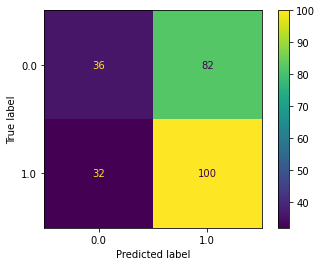

              precision    recall  f1-score   support

         0.0       0.53      0.31      0.39       118
         1.0       0.55      0.76      0.64       132

    accuracy                           0.54       250
   macro avg       0.54      0.53      0.51       250
weighted avg       0.54      0.54      0.52       250



In [10]:
log_reg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
log_reg.fit(X_train, y_train)
# 10- fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(log_reg, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print('10-fold cross validation metrics:')
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
print("---------"*10)
print("\n")
print("Testing results:")
predictions = log_reg.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=log_reg.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, log_reg.predict(X_test)))

### Naive Bayes

In [11]:
model = GaussianNB()
#define grid search parameters
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_nb, n_jobs=-1, cv=cv, \
                           scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.567431 using {'var_smoothing': 0.2848035868435802}


10-fold cross validation metrics:
Mean accs :  0.5674309764309763
Mean f1_macro 0.5544230562003155
Mean precision 0.5877391811857017
Mean recall 0.5580515297906602
------------------------------------------------------------------------------------------


Testing results:


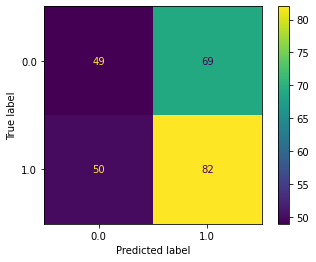

              precision    recall  f1-score   support

         0.0       0.49      0.42      0.45       118
         1.0       0.54      0.62      0.58       132

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.52      0.52      0.52       250



In [12]:
nb = GaussianNB(var_smoothing=0.2848035868435802)
nb.fit(X_train, y_train)
# 10 fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(nb, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print('10-fold cross validation metrics:')
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
print("---------"*10)
print("\n")
print("Testing results:")
predictions = nb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=nb.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, nb.predict(X_test)))

### Random Forest

In [13]:
model = RandomForestClassifier()
#define grid search parameters
n_estimators = [10, 100, 200, 1000]
max_features = [1, 2, 3, 4, 5, 6]
criterions = ['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features, criterion=criterions)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.529873 using {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100}


10-fold cross validation metrics:
Mean accs :  0.5236801346801346
Mean f1_macro 0.5123714999426986
Mean precision 0.5548018787028628
Mean recall 0.5155984970477724


Testing results:


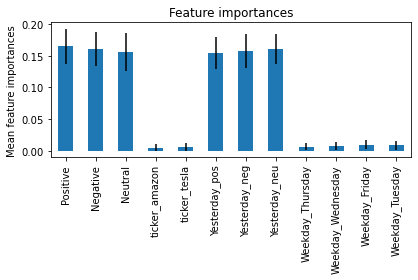

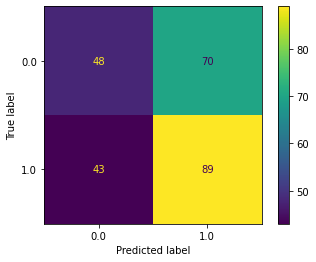

              precision    recall  f1-score   support

         0.0       0.53      0.41      0.46       118
         1.0       0.56      0.67      0.61       132

    accuracy                           0.55       250
   macro avg       0.54      0.54      0.54       250
weighted avg       0.54      0.55      0.54       250



In [19]:
rf = RandomForestClassifier(n_estimators =100 , max_features=1,criterion='entropy', random_state=3)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=['Positive', 'Negative', 'Neutral','ticker_amazon', 'ticker_tesla',\
                            'Yesterday_pos','Yesterday_neg','Yesterday_neu','Weekday_Thursday',\
                            'Weekday_Wednesday','Weekday_Friday','Weekday_Tuesday'])

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean feature importances")
fig.tight_layout()


# 10 fold cross validation
print('10-fold cross validation metrics:')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
cv_scores = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
 
print("\n")
print("Testing results:")
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, rf.predict(X_test)))

## Support vector machines

In [15]:
model = svm.SVC()
#define grid search parameters
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.572822 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.556801 (0.038838) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.572822 (0.045395) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.488953 (0.053851) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.565155 (0.037356) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.567468 (0.040944) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.484630 (0.053400) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.559805 (0.032134) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.572448 (0.034211) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.497013 (0.048493) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.568421 (0.037039) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.553424 (0.022155) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.504323 (0.036226) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.533394 (0.012697) with: {'C': 0.01, 'gamma': 'scale', 

10-fold cross validation metrics:
Mean accs :  0.5728215488215489
Mean f1_macro 0.5621811366669132
Mean precision 0.5932982096975971
Mean recall 0.5641358024691357


Testing results:


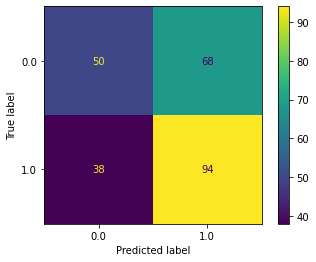

              precision    recall  f1-score   support

         0.0       0.57      0.42      0.49       118
         1.0       0.58      0.71      0.64       132

    accuracy                           0.58       250
   macro avg       0.57      0.57      0.56       250
weighted avg       0.57      0.58      0.57       250



In [16]:
svm = svm.SVC(kernel='rbf', C=50, gamma='scale')
svm.fit(X_train, y_train)

# 10 fold cross validation
print('10-fold cross validation metrics:')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_validate(svm, X_train, y_train, cv=cv, scoring=scoring)
accs = cv_scores['test_accuracy'].mean()
print("Mean accs : ",accs)
f1_macros = cv_scores['test_f1_macro'].mean()
print("Mean f1_macro", f1_macros)
prec = cv_scores['test_precision'].mean()
print("Mean precision", prec)
recall = cv_scores['test_recall'].mean()
print("Mean recall", recall)
 
print("\n")
print("Testing results:")
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svm.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, svm.predict(X_test)))